<a href="https://www.kaggle.com/code/clemwo/credit-card-fraud-detection-proper-modeling?scriptVersionId=194249653" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
import copy
import shap
import optuna
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from tabulate import tabulate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from optuna.samplers import TPESampler
from sklearn.metrics import precision_score, precision_recall_curve, average_precision_score
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    brier_score_loss, 
    confusion_matrix, 
    average_precision_score, 
)
from sklearn.model_selection import TimeSeriesSplit 
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/creditcardfraud/creditcard.csv


<img src="https://www.abclegal.com/hs-fs/hubfs/iStock-495421971%20(1).jpg?width=1200&name=iStock-495421971%20(1).jpg" alt="Credit Card Fraud" width="800"/>


# 🤖 Credit Card Fraud Detection 💳 Machine Learning

In this notebook we are going to perform exploratory data analysis and iterate through different machine learning models using [Kaggles Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) dataset. The objective is to build a model which predicts if a transaction is fraudulent (1) or genuine (0) as accuractely as possible. 

In [2]:
creditcard = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
print(f"Rows: {creditcard.shape[0]:,}")
print(f"Cols: {creditcard.shape[1]:,}")
creditcard.head(3)

Rows: 284,807
Cols: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


The dataset consists of 31 columns out of which 28 are anonymized. The named and defined columns are: 

| Column | Description |
| ------ | ----------- |
| `Time` | Number of seconds elapsed between this transaction and the first transaction in the dataset. |
| `Amount` | Amount of the transaction. |
| `Class` | Target class. $0$ if genuine, $1$ if fraudulent. |

In [3]:
creditcard[['Time', 'Amount', 'Class']].dtypes 

Time      float64
Amount    float64
Class       int64
dtype: object

In [4]:
# ----------------------------- #
# Add some time-related columns #
# ----------------------------- #

creditcard['Time_Hours'] = creditcard['Time'] / 3_600
creditcard['Time_Days'] = creditcard['Time_Hours'] / 24
creditcard['Hour_of_Day'] = creditcard['Time'] % 86_400 / 3_600

# Encode as cyclic features which can help ML models understand cyclic nature of time.
creditcard['Hour_sin'] = np.sin(2 * np.pi * creditcard['Hour_of_Day'] / 24)
creditcard['Hour_cos'] = np.cos(2 * np.pi * creditcard['Hour_of_Day'] / 24)

creditcard[['Time', 'Time_Hours', 'Time_Days', 'Hour_of_Day', 'Hour_sin', 'Hour_cos']].head(5)

,Time,Time_Hours,Time_Days,Hour_of_Day,Hour_sin,Hour_cos
0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
1,0.0,0.000000,0.000000,0.000000,0.000000,1.0
2,1.0,0.000278,0.000012,0.000278,0.000073,1.0
3,1.0,0.000278,0.000012,0.000278,0.000073,1.0
4,2.0,0.000556,0.000023,0.000556,0.000145,1.0


# 🌐 Global Variables

In [5]:
# ------------------------------------------------- #
# Global Variables to use across the whole notebook #
# ------------------------------------------------- #
 
RANDOM_STATE = 42

TS = 'Time'
TARGET = 'Class'
MONEY = 'Amount'
LABELS = ['Genuine', 'Fraudulent']

# 🛠️ Helper Methods

In [6]:
def return_performance_statistics(model, X_tr, y_tr, X_te, y_te):
    results = {
        'train': {
            'accuracy': None,
            'precision': None,
            'recall': None,
            'auc_roc': None,
            'ap': None,
            'brier': None
        },
        'test': {
            'accuracy': None,
            'precision': None,
            'recall': None,
            'auc_roc': None,
            'ap': None,
            'brier': None
        },
    }

    # --------- #
    # TRAIN_VAL #
    # --------- #
    y_proba_train = model.predict_proba(X_tr)[:, 1]
    y_pred_train = model.predict(X_tr)

    results['train']['accuracy'] = accuracy_score(y_tr, y_pred_train)
    results['train']['precision'] = precision_score(y_tr, y_pred_train)
    results['train']['recall'] = recall_score(y_tr, y_pred_train)
    results['train']['auc_roc'] = roc_auc_score(y_tr, y_proba_train)
    results['train']['ap'] = average_precision_score(y_tr, y_proba_train)
    results['train']['brier'] = brier_score_loss(y_tr, y_proba_train)

    # ---- #
    # TEST #
    # ---- #

    y_proba_test = model.predict_proba(X_te)[:, 1]
    y_proba_test = pd.Series(y_proba_test, index=y_te.index)
    y_pred_test = model.predict(X_te)

    results['test']['accuracy'] = accuracy_score(y_te, y_pred_test)
    results['test']['precision'] = precision_score(y_te, y_pred_test)
    results['test']['recall'] = recall_score(y_te, y_pred_test)
    results['test']['auc_roc'] = roc_auc_score(y_te, y_proba_test)
    results['test']['ap'] = average_precision_score(y_te, y_proba_test)
    results['test']['brier'] = brier_score_loss(y_te, y_proba_test)

    return results

# 1️⃣st PART : Exploratory Data Analysis (EDA)

## 📂 Fraud Overview

In [7]:
# --- Get basic statistics ---
pd.DataFrame(
    {
        'Data Type': creditcard.dtypes,
        'Missing Count (#)': creditcard.isnull().sum(),
        'Missing Rate (%)': 100 * creditcard.isnull().mean(),
        'Unique Count (#)': creditcard.nunique(),
        'Unique Rate (%)': round(100 * creditcard.nunique() / creditcard.shape[0], 2),
        'Duplicates Count (#)': [creditcard[c].duplicated().sum() for c in creditcard.columns],
        'Duplicates Rate (%)': [round(100 * creditcard[c].duplicated().sum() / creditcard.shape[0], 2) for c in creditcard.columns],
    }
)

,Data Type,Missing Count (#),Missing Rate (%),Unique Count (#),Unique Rate (%),Duplicates Count (#),Duplicates Rate (%)
Time,float64,0,0.0,124592,43.75,160215,56.25
V1,float64,0,0.0,275663,96.79,9144,3.21
V2,float64,0,0.0,275663,96.79,9144,3.21
V3,float64,0,0.0,275663,96.79,9144,3.21
V4,float64,0,0.0,275663,96.79,9144,3.21
V5,float64,0,0.0,275663,96.79,9144,3.21
V6,float64,0,0.0,275663,96.79,9144,3.21
V7,float64,0,0.0,275663,96.79,9144,3.21
V8,float64,0,0.0,275663,96.79,9144,3.21
V9,float64,0,0.0,275663,96.79,9144,3.21


There are no missing values in the dataset 😊. 

In [8]:
# --- Understand overall fraud behavior ---
100*creditcard[TARGET].value_counts(normalize=True)

overall_fraud_count = creditcard[TARGET].sum()
overall_fraud_rate = overall_fraud_count / creditcard.shape[0]
non_fraud_count = creditcard.shape[0] - overall_fraud_count
overall_non_fraud_rate = non_fraud_count / creditcard.shape[0]

pd.DataFrame({
    'Metric': ['Number of Genuine', 'Number of Fraud', 'Genuine Rate (%)', 'Fraud Rate (%)'],
    'Value': [non_fraud_count, overall_fraud_count, 100*overall_non_fraud_rate, 100*overall_fraud_rate]
})

,Metric,Value
0,Number of Genuine,284315.000000
1,Number of Fraud,492.000000
2,Genuine Rate (%),99.827251
3,Fraud Rate (%),0.172749


The dataset is __highly imbalanced__. It contains only 492 fraudulent transactions, which results in an __overall fraud rate of 0.173%__. Consequently 99.8% of all transactions are genuine. Therefore, later we need to perform some techniques to handle this imbalance. 

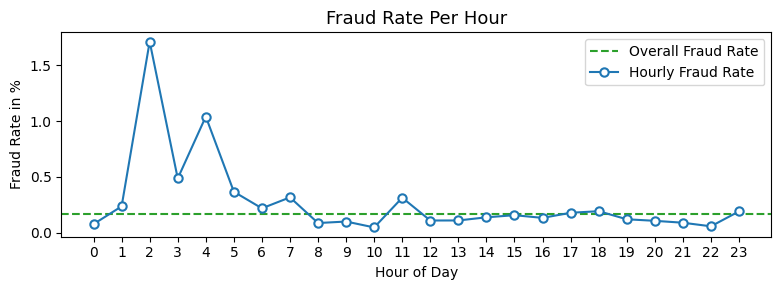

In [9]:
# --------- #
# Preparing #
# --------- #

creditcard['Hour'] = creditcard['Time'] // 3_600 % 24
hourly_fraud_rate = creditcard.groupby('Hour')['Class'].mean().reset_index()
overall_fraud_rate = creditcard['Class'].mean() * 100
hourly_fraud_rate['Class'] *= 100


# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(8, 3))
plt.axhline(y=overall_fraud_rate, color='C2', linestyle='--', label='Overall Fraud Rate')
plt.plot(hourly_fraud_rate['Hour'], hourly_fraud_rate['Class'], 
         linestyle='-', marker='o', markerfacecolor='white', markeredgewidth=1.5, color='C0', label='Hourly Fraud Rate')
plt.title('Fraud Rate Per Hour', fontsize=13)
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate in %')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

__Observations__

- The dataset consists of roughly 24 hours of data.
- In the 2nd hour after the first transaction the fraud fraud is the highest, having a value of nearly 1.75%. 
- The hourly fraud rates stabilizes after the 8th hour.

__Insights__

> Most fraud happened in the early morning between 2am and 4am.

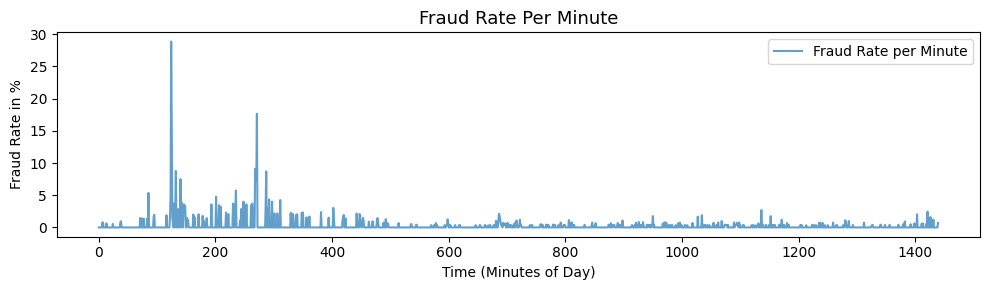

In [10]:
# --------- #
# Preparing #
# --------- #

creditcard['Minute'] = (creditcard['Time'] // 60) % 1440
minute_fraud_rate = creditcard.groupby('Minute')['Class'].mean().reset_index()
minute_fraud_rate['Class'] *= 100


# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(10, 3))

plt.plot(minute_fraud_rate['Minute'], minute_fraud_rate['Class'], linestyle='-', color='C0', 
         label='Fraud Rate per Minute', alpha=0.7)
plt.title('Fraud Rate Per Minute', fontsize=13)
plt.xlabel('Time (Minutes of Day)')
plt.ylabel('Fraud Rate in %')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()

## 💸 Amount

In this subsection we are going to investigate the amount column `Amount`.

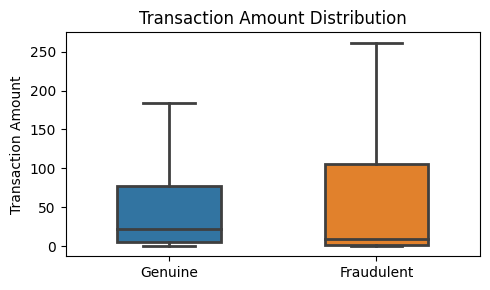

In [11]:
fig, axes = plt.subplots(figsize=(5, 3))

sns.boxplot(data=creditcard, x=TARGET, y=MONEY,
            linewidth=2, width=0.5, showfliers=False, ax=axes)
axes.set_title('Transaction Amount Distribution')
axes.set_xlabel('')
axes.set_ylabel('Transaction Amount')
axes.set_xticklabels(LABELS)

plt.tight_layout()
plt.show()

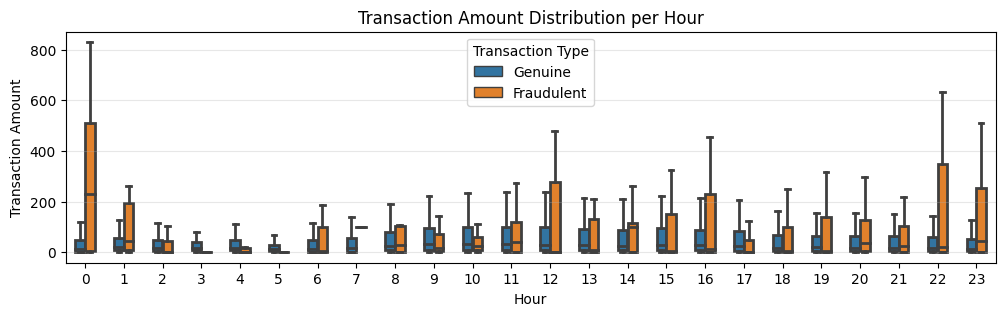

In [12]:
plt.figure(figsize=(12, 3))

sns.boxplot(data=creditcard, x='Hour', y=MONEY, hue=TARGET, linewidth=2, width=0.5, showfliers=False)
plt.title('Transaction Amount Distribution per Hour')
plt.xlabel('Hour')
plt.ylabel('Transaction Amount')

handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Genuine' if label == '0' else 'Fraudulent' for label in labels]
plt.legend(handles, labels, title='Transaction Type')

plt.xticks(ticks=plt.xticks()[0], labels=[int(x) for x in plt.xticks()[0]])
plt.grid(True, axis='y', alpha=0.3)

plt.show()

## 🧰 Pre-Processing

Before we build some machine learning models we need to preapre our data. We will use a 

- `train` set to train our basic model parameters
- `validation` set to use as validation during cross validation and to tune our hyperparameters
- `test` as "simulation" for actual data, thus, we are going to do nothing else other then predicting on that set after we trained our model

We need to be aware of a couple points when working with time-dependent data.

1. 🚨 When performing the `train`-`test`-split we need to split by time. Otherwise, we would train on future data which is not how reality works. We should therefore only predict on data which is time-wise __after__ our training data.
2. 🚨 When performing cross validation we need to perform time dependent time series splits. A great library to do that is sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). The reason for that is the same as for point 1, we simply don't want to tune our hyperparameters on future data, which would be the case if we would use classical cross validation techniques like [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) of [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). 

In [13]:
creditcard.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,Amount,Class,Time_Hours,Time_Days,Hour_of_Day,Hour_sin,Hour_cos,Hour,Minute
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.021053,149.62,0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.014724,2.69,0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.059752,378.66,0,0.000278,0.000012,0.000278,0.000073,1.0,0.0,0.0


In [14]:
# ------------------------------- #
# Split dataset in TRAIN and TEST #
# ------------------------------- #

creditcard = creditcard.sort_values(by='Hour').reset_index(drop=True)

# Predict everything after the split_hour.
split_hour = 20

train = creditcard[creditcard['Hour'] <= split_hour]
test = creditcard[creditcard['Hour'] > split_hour]

N_train, N_test = train.shape[0], test.shape[0]
N_total = N_train + N_test
pct_train, pct_test = 100 * N_train / N_total, 100 * N_test / N_total
frauds_train, frauds_test = train[train['Class']==1].shape[0], test[test['Class']==1].shape[0]

print(f"""Statistics
==========
{4*' '}TRAIN
{8*' '}  Rows: {N_train:8,} ({pct_train:0.2f} %)
{8*' '}Frauds: {frauds_train:8,}  ({100*frauds_train/N_train:0.4f} %) = {100*frauds_train/(frauds_train+frauds_test):0.4f} % of all frauds
{4*' '}TEST
{8*' '}  Rows: {N_test:8,} ({pct_test:0.2f} %)
{8*' '}Frauds: {frauds_test:8,}  ({100*frauds_test/N_test:0.4f} %) = {100*frauds_test/(frauds_train+frauds_test):0.4f} % of all frauds
""")

Statistics
    TRAIN
          Rows:  240,725 (84.52 %)
        Frauds:      446  (0.1853 %) = 90.6504 % of all frauds
    TEST
          Rows:   44,082 (15.48 %)
        Frauds:       46  (0.1044 %) = 9.3496 % of all frauds



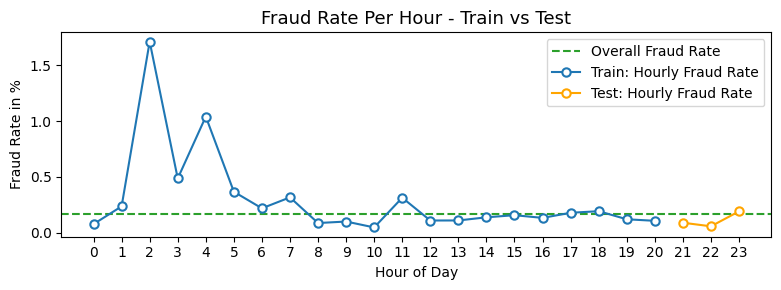

In [15]:
# --------- #
# Preparing #
# --------- #

overall_fraud_rate = creditcard['Class'].mean() * 100

hourly_fraud_rate_train = train.groupby('Hour')['Class'].mean().reset_index()
hourly_fraud_rate_test = test.groupby('Hour')['Class'].mean().reset_index()

hourly_fraud_rate_train['Class'] *= 100
hourly_fraud_rate_test['Class'] *= 100


# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(8, 3))

plt.axhline(y=overall_fraud_rate, color='C2', linestyle='--', label='Overall Fraud Rate')
plt.plot(hourly_fraud_rate_train['Hour'], hourly_fraud_rate_train['Class'], 
         linestyle='-', marker='o', markerfacecolor='white', markeredgewidth=1.5, color='C0', 
         label='Train: Hourly Fraud Rate')
plt.plot(hourly_fraud_rate_test['Hour'], hourly_fraud_rate_test['Class'], 
         linestyle='-', marker='o', markerfacecolor='white', markeredgewidth=1.5, color='orange', 
         label='Test: Hourly Fraud Rate')
plt.title('Fraud Rate Per Hour - Train vs Test', fontsize=13)
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate in %')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()

In [16]:
BASE_FEATURES = [
    'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
    'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    MONEY
]

In [17]:
# --- Split datasets to train and predict on ---
X_train, y_train = train[BASE_FEATURES], train[TARGET]
X_test, y_test = test[BASE_FEATURES], test[TARGET]

# 2️⃣nd PART : Modeling

Now we are going to perform some proper machine learning on the dataset. We will iterate through different models and will try to attack the errors and problems of the previous iteration. The following gives a rough overview of the performed iterations: 

| Iteration | Description | 
| --------- | ----------- |
| `v1` | Basic XGBoost model w/o cross validation and w/o hyperparameter tuning. |
| `v2` | XGBoost model w/ cross validation and w/o hyperparamter tuning. |

## 🏋️‍ v1 - Training

In [18]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## 🕵️‍ v1 - Validation

In [19]:
results = return_performance_statistics(model, X_train, y_train, X_test, y_test)
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC ROC', 'AP', 'Brier'],
    'Train': [
        results.get('train').get('accuracy'),
        results.get('train').get('precision'),
        results.get('train').get('recall'),
        results.get('train').get('auc_roc'),
        results.get('train').get('ap'),
        results.get('train').get('brier'),
    ],
    'Test': [
        results.get('test').get('accuracy'),
        results.get('test').get('precision'),
        results.get('test').get('recall'),
        results.get('test').get('auc_roc'),
        results.get('test').get('ap'),
        results.get('test').get('brier'),
    ],
})
metrics_df

,Metric,Train,Test
0,Accuracy,1.000000,0.999569
1,Precision,1.000000,0.864865
2,Recall,1.000000,0.695652
3,AUC ROC,1.000000,0.958466
4,AP,1.000000,0.743014
5,Brier,0.000002,0.000369


__Observations__

Since the dataset is highly imbalanced we should focus our investigation on the Average Precision (AP) metric as well as one the Brier Score. AP should be as high as possible while the brier score should be as low as possible. The model is quiet predictive and shows a perfect AP on the `Train` set. However the AP on the `Test` set, even though being high, is significantly lower than on the `Train` set. This is a sign of __large overfitting__. The Brier scores are both very low, even though being much higher on the `Test` set. This could be a sign of bad calibration. 

In [20]:
LABELS = ['Genuine', 'Fraud']

cm = confusion_matrix(y_train, model.predict(X_train))
print(f"{' TRAINING ':=^50}")
print(tabulate(cm, 
               headers=[f'Pred {l}' for l in LABELS],
               showindex=[f'True {l}' for l in LABELS],
               floatfmt=",.0f", tablefmt="simple_grid"))
print()

cm = confusion_matrix(y_test, model.predict(X_test))
print(f"{' TEST ':=^50}")
print(tabulate(cm, 
               headers=[f'Pred {l}' for l in LABELS],
               showindex=[f'True {l}' for l in LABELS],
               floatfmt=",.0f", tablefmt="simple_grid"))

==================== TRAINING ====================
┌──────────────┬────────────────┬──────────────┐
│              │   Pred Genuine │   Pred Fraud │
├──────────────┼────────────────┼──────────────┤
│ True Genuine │        240,279 │            0 │
├──────────────┼────────────────┼──────────────┤
│ True Fraud   │              0 │          446 │
└──────────────┴────────────────┴──────────────┘

====================== TEST ======================
┌──────────────┬────────────────┬──────────────┐
│              │   Pred Genuine │   Pred Fraud │
├──────────────┼────────────────┼──────────────┤
│ True Genuine │         44,031 │            5 │
├──────────────┼────────────────┼──────────────┤
│ True Fraud   │             14 │           32 │
└──────────────┴────────────────┴──────────────┘


## 💰 v1 - Monetary Impact Analysis

In [21]:
LABELS = ['Genuine', 'Fraud']
datasets = ['TRAINING', 'TEST']
data = [(y_train, X_train), (y_test, X_test)]

def calculate_monetary_impact(y_true, y_pred, amt):
    TP = amt[(y_true == 1) & (y_pred == 1)].sum()
    TN = amt[(y_true == 0) & (y_pred == 0)].sum()
    FP = amt[(y_true == 0) & (y_pred == 1)].sum()
    FN = amt[(y_true == 1) & (y_pred == 0)].sum()
    return TP, TN, FP, FN

results = []

for (y, X), dataset in zip(data, datasets):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    TP, TN, FP, FN = calculate_monetary_impact(y, y_pred, X[MONEY])
    results.append([dataset, cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0], TP, TN, FP, FN])

results_df = pd.DataFrame(results, columns=['Dataset', 'TP', 'TN', 'FP', 'FN', 'TP Amt', 'TN Amt', 'FP Amt', 'FN Amt'])
results_df

,Dataset,TP,TN,FP,FN,TP Amt,TN Amt,FP Amt,FN Amt
0,TRAINING,446,240279,0,0,54513.35,22006732.53,0.00,0.00
1,TEST,32,44031,5,14,4054.33,3069919.46,25810.05,1560.29


## 📊 v1 - SHAP Insights

In this section we are going to take a look at different kinds of plot to visualize SHAP values, namely [beeswarm](https://shap.readthedocs.io/en/latest/generated/shap.plots.beeswarm.html), [bar](https://shap.readthedocs.io/en/latest/generated/shap.plots.bar.html), [waterfall](https://shap.readthedocs.io/en/latest/generated/shap.plots.waterfall.html) plots. 

| SHAP Plot | Short Description | 
| --------- | ----------------- |
| [beeswarm](https://shap.readthedocs.io/en/latest/generated/shap.plots.beeswarm.html) | Visualizes SHAP values for individual predictions, revealing feature importance and interaction patterns. |
| [bar](https://shap.readthedocs.io/en/latest/generated/shap.plots.bar.html) | Displays average SHAP values for each feature, showing their overall impact on model predictions. |
| [waterfall](https://shap.readthedocs.io/en/latest/generated/shap.plots.waterfall.html) | Breaks down a single prediction into its contributing SHAP values, showing how features push the prediction away from the base value. |

In [22]:
# Sample the data. Otherwise SHAP value calculation takes too long.
X_test_sampled = X_test.sample(frac=0.1, random_state=RANDOM_STATE, replace=False)

# Calculate SHAP values.
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_sampled)

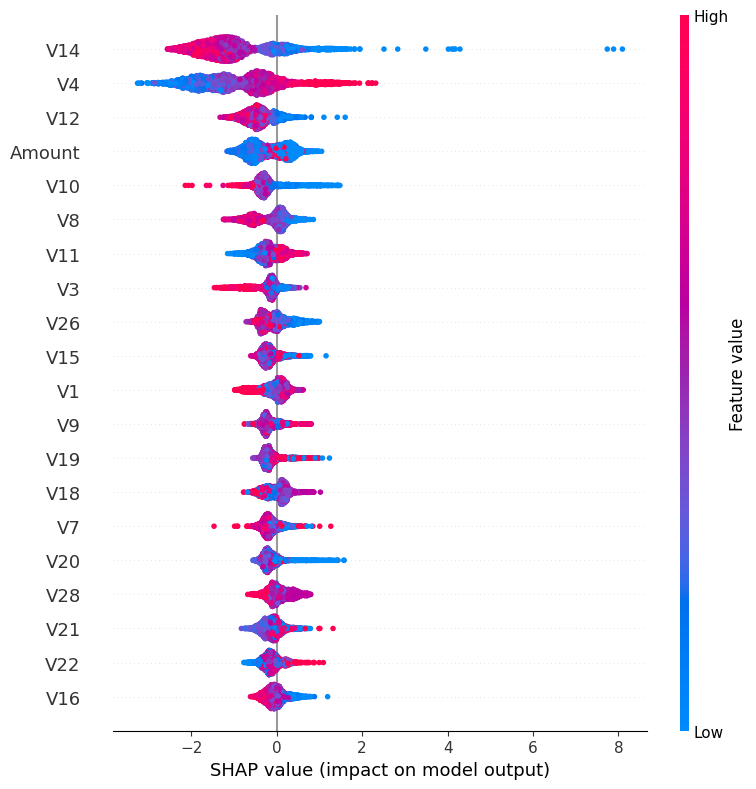

In [23]:
assert shap_values.shape[0] == X_test_sampled.shape[0], "ERROR: Mismatch in number of samples!"
assert shap_values.shape[1] == X_test_sampled.shape[1], "ERROR: Mismatch in number of features!"

# --- SHAP Summary Plot on Test Set Sample ---
shap.summary_plot(shap_values, X_test_sampled, plot_size=(8, 8))

Now let's take a look at the SHAP bar plot which will take the absolute value of each feature over all the instances (rows) of the dataset (Source: [shap.readthedocs](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#The-additive-nature-of-Shapley-values)).

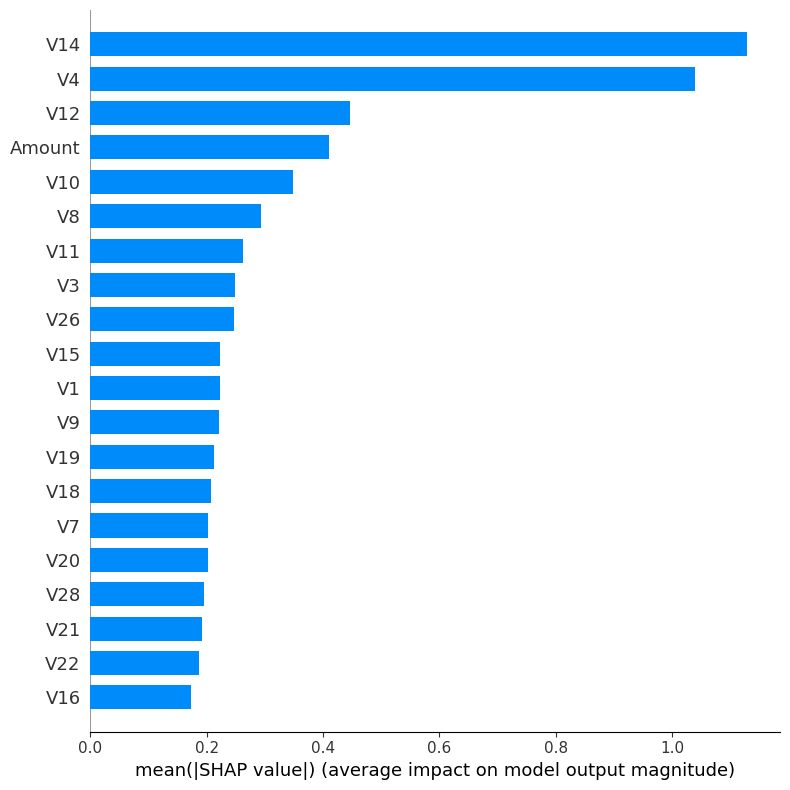

In [24]:
shap.summary_plot(shap_values, X_test_sampled, plot_type='bar', plot_size=(8, 8))

Additionally, we can take alook at the influence of features on single predictions. For that it's [SHAP's waterfall plot](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#The-additive-nature-of-Shapley-values) can be used. The intuition of the waterfall plot is that SHAP values of all the input features will always sum up to the difference between _baseline (expected) model_ and the _current model_ output $f(X)$ for the prediction being explained. The waterfall makes this easy to see because it starts at the background prior expecation $\mathbb{E}[f(X)]$, and then adds features one at a time until the current model out $f(X)$ is reached. 

SHAP Waterfall plot for a Fraudulent (1) example
Predicted class: 1


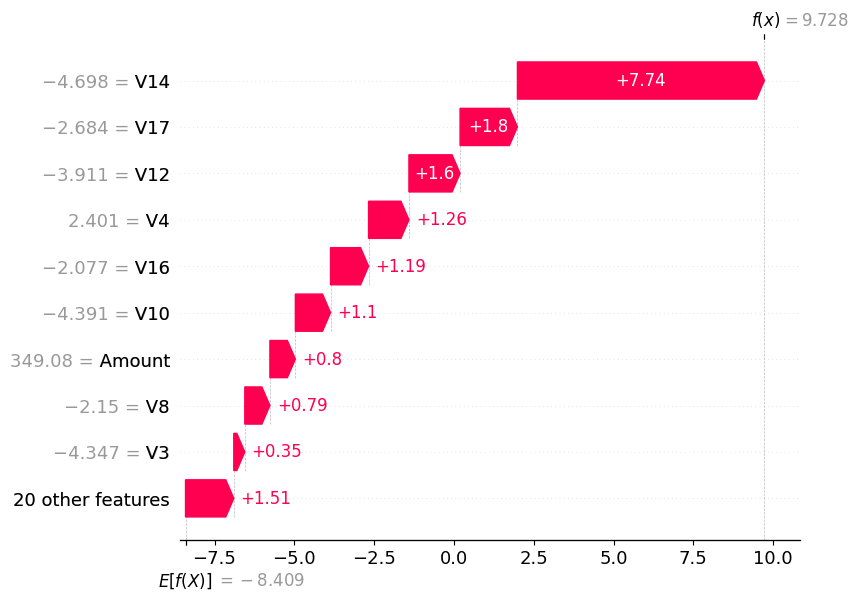

In [25]:
# --- Plot the SHAP values for a fraud example  ---

y_test_sampled = y_test.loc[X_test_sampled.index]
sampled_index = y_test_sampled[y_test_sampled == 1].sample(1, random_state=RANDOM_STATE).index[0]
predicted_class = model.predict([X_test_sampled.loc[sampled_index].values]).item()
instance_index = X_test_sampled.index.get_loc(sampled_index)

specific_shap_values = shap_values[instance_index, :]
specific_expected_value = explainer.expected_value

specific_explanation = shap.Explanation(values=specific_shap_values,
                                        base_values=specific_expected_value,
                                        data=X_test_sampled.iloc[instance_index],
                                        feature_names=X_test_sampled.columns)

print("SHAP Waterfall plot for a Fraudulent (1) example")
print(f"Predicted class: {predicted_class}")
shap.waterfall_plot(specific_explanation)

SHAP Waterfall plot for a Genuine (0) example
Predicted class: 0


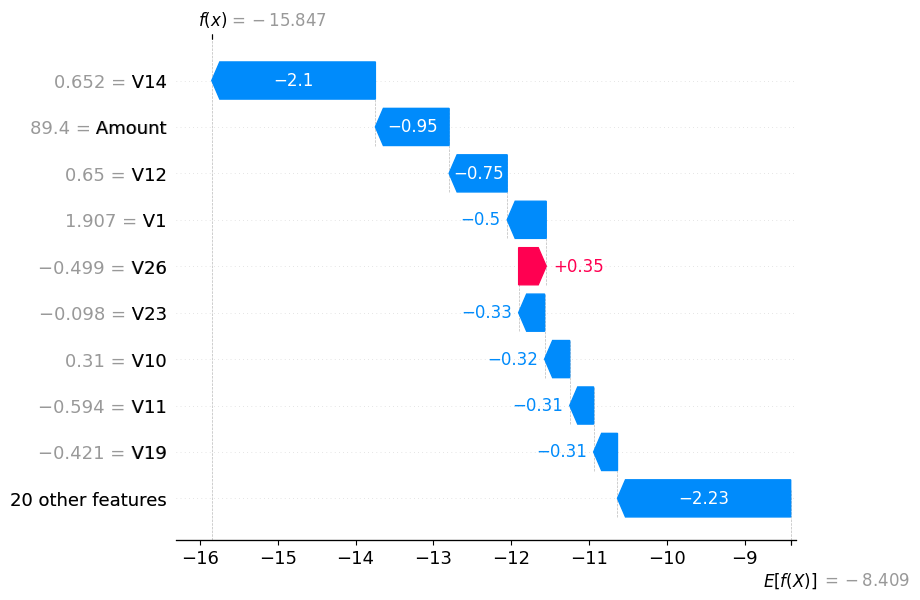

In [26]:
# --- Plot the SHAP values for a genuine example  ---

y_test_sampled = y_test.loc[X_test_sampled.index]
sampled_index = y_test_sampled[y_test_sampled == 0].sample(1, random_state=RANDOM_STATE).index[0]
predicted_class = model.predict([X_test_sampled.loc[sampled_index].values]).item()
instance_index = X_test_sampled.index.get_loc(sampled_index)

specific_shap_values = shap_values[instance_index, :]
specific_expected_value = explainer.expected_value

specific_explanation = shap.Explanation(values=specific_shap_values,
                                        base_values=specific_expected_value,
                                        data=X_test_sampled.iloc[instance_index],
                                        feature_names=X_test_sampled.columns)

print("SHAP Waterfall plot for a Genuine (0) example")
print(f"Predicted class: {predicted_class}")
shap.waterfall_plot(specific_explanation)

## ⏱️ v2 - TimeSeriesSplit

Now we are going to perform the aforementioned time series split to the perform hyperparameter tuning on it. Let's take a look at what `TimeSeriesSplit` is doing. 

In [27]:
# --- To better understand for the reader what TSP is doing (compared to classical CV) ---

tscv = TimeSeriesSplit(n_splits=5)
timestamps = train.loc[X_train.index]['Hour']

split_num = 1
print("Hour time ranges for each TimeSeriesSplit")
print("=========================================")
for train_index, test_index in tscv.split(X_train):
    train_times = timestamps.iloc[train_index]
    test_times = timestamps.iloc[test_index]
    print(f"Split {split_num}:")
    print(f"  Train: {train_times.min():2.0f}  to  {train_times.max():2.0f}")
    print(f"  Test : {test_times.min():2.0f}  to  {test_times.max():.0f}")
    split_num += 1

Hour time ranges for each TimeSeriesSplit
Split 1:
  Train:  0  to   8
  Test :  8  to  11
Split 2:
  Train:  0  to  11
  Test : 11  to  13
Split 3:
  Train:  0  to  13
  Test : 13  to  16
Split 4:
  Train:  0  to  16
  Test : 16  to  18
Split 5:
  Train:  0  to  18
  Test : 18  to  20


We see that since we defined `n_splits` as 5 `TimeSeriesSplit` splits the data into 5 folds. The 1st fold is time-wise _before_ all the other folds. The 2nd fold is contains the 1st fold's `Test` data in it's `Train` data and has additional data as `Test`. And so on. The last fold contains all the data up until the 18th hour as it's `Train` data and the hours after that as `Test`. 

It becomes clear that the earlier split's will have worse performance. Simply because they contain less data. Split 1 has less data then all the other folds, and Split 5 has the most data.

## 🏋️‍ v2 - Training with Hyperparametertuning

Now we are going to perform Bayesian Hyperparametertuning using the time series splits from before. 

In [28]:
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []

N_SPLITS = 5


# ----------------------------- #
# Define the objective function #
# ----------------------------- #

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "early_stopping_round": 10,
        'use_label_encoder': False,
        'verbosity': 0,
        # --- for overfitting ---
        'max_depth': trial.suggest_int('max_depth', 1, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        # --- less sensitive to noise ---
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
    }
    
    tsp = TimeSeriesSplit(n_splits=N_SPLITS).split(X_train)
    
    train_precision_scores = []
    val_precision_scores = []
    train_recall_scores = []
    val_recall_scores = []
    
    for train_index, val_index in tsp:
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model = xgb.XGBClassifier(**params, random_state=RANDOM_STATE, n_jobs=-1)
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  verbose=False)
        
        y_train_pred = model.predict(X_train_fold)
        y_val_pred = model.predict(X_val_fold)
        
        train_precision = precision_score(y_train_fold, y_train_pred)
        val_precision = precision_score(y_val_fold, y_val_pred)
        train_recall = recall_score(y_train_fold, y_train_pred)
        val_recall = recall_score(y_val_fold, y_val_pred)
#         print(f"Train Precision: {train_precision:.2f}  Val Precision: {val_precision:.2f}")
        
        train_precision_scores.append(train_precision)
        val_precision_scores.append(val_precision)
        train_recall_scores.append(train_recall)
        val_recall_scores.append(val_recall)
    
    train_precisions.append(np.mean(train_precision_scores))
    val_precisions.append(np.mean(val_precision_scores))
    train_recalls.append(np.mean(train_recall_scores))
    val_recalls.append(np.mean(val_recall_scores))

    mu_train_precisions = np.mean(train_precisions)
    sd_train_precision = np.std(train_precisions)
    mu_val_precisions = np.mean(val_precision_scores)
    sd_val_precisions = np.std(val_precision_scores)
    
#     print(f"Train Precision: {mu_train_precisions:.2f} += {sd_train_precision:.2f}  |  Validation Precision: {mu_val_precisions:.2f} += {sd_val_precisions:.2f}")
    
    return np.mean(val_precision_scores)


# --------------------------------- #
# Run Bayesian Hyperparametertuning #
# --------------------------------- #

N_TRIALS = 100  # Number of Bayesian trials.

study = optuna.create_study(study_name='v2',
                            direction='maximize', 
                            sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=N_TRIALS)

print(f"Best hyperparameters: {study.best_params}")

[I 2024-08-27 08:48:23,511] A new study created in memory with name: v2
[I 2024-08-27 08:48:44,342] Trial 0 finished with value: 0.947031523129084 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'gamma': 0.7319939418114051, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309}. Best is trial 0 with value: 0.947031523129084.
[I 2024-08-27 08:49:04,192] Trial 1 finished with value: 0.9530289446809095 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8661761457749352, 'subsample': 0.8803345035229626, 'colsample_bytree': 0.9124217733388136}. Best is trial 1 with value: 0.9530289446809095.
[I 2024-08-27 08:49:21,697] Trial 2 finished with value: 0.8892664499243447 and parameters: {'max_depth': 1, 'min_child_weight': 10, 'gamma': 0.8324426408004217, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302}. Best is trial 1 with value: 0.9530289446809095.
[I 2024-08-27 08:49:42,055] Trial 3 finished with value: 0.9652178932178932 and

Best hyperparameters: {'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.5200680211778108, 'subsample': 0.8640130838029838, 'colsample_bytree': 0.7554563366576581}


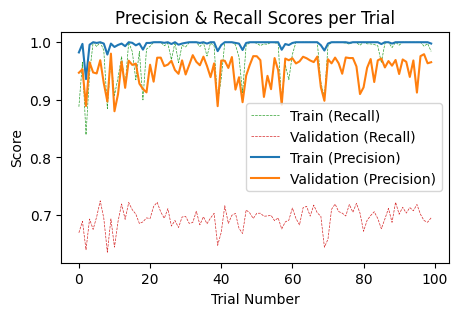

In [29]:
plt.figure(figsize=(5, 3))

plt.plot(np.arange(N_TRIALS), train_recalls, color='C2', linestyle='--', lw=0.5, label='Train (Recall)');
plt.plot(np.arange(N_TRIALS), val_recalls, color='C3', linestyle='--', lw=0.5, label='Validation (Recall)');
plt.plot(np.arange(N_TRIALS), train_precisions, color='C0', label='Train (Precision)');
plt.plot(np.arange(N_TRIALS), val_precisions, color='C1', label='Validation (Precision)');
plt.xlabel('Trial Number');
plt.ylabel('Score');
plt.title('Precision & Recall Scores per Trial');
plt.legend();

plt.show()

In [30]:
# --- Train the final model with the best hyperparameters on the whole train set ---

best_params = study.best_params
model = xgb.XGBClassifier(**best_params, early_stopping_round=10, eval_metric='logloss')
model.fit(X_train, y_train, verbose=0)

joblib.dump(model, 'model_v2.pkl')

[09:24:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_round" } are not used.



['model_v2.pkl']

## 🕵️‍ v2 - Validation

In [31]:
# --- Print the performance metrics ---

loaded_model = joblib.load('model_v2.pkl')
results = return_performance_statistics(loaded_model, X_train, y_train, X_test, y_test)
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC ROC', 'AP', 'Brier'],
    'Train': [
        results.get('train').get('accuracy'),
        results.get('train').get('precision'),
        results.get('train').get('recall'),
        results.get('train').get('auc_roc'),
        results.get('train').get('ap'),
        results.get('train').get('brier'),
    ],
    'Test': [
        results.get('test').get('accuracy'),
        results.get('test').get('precision'),
        results.get('test').get('recall'),
        results.get('test').get('auc_roc'),
        results.get('test').get('ap'),
        results.get('test').get('brier'),
    ],
})
metrics_df

,Metric,Train,Test
0,Accuracy,0.999971,0.999614
1,Precision,1.000000,0.914286
2,Recall,0.984305,0.695652
3,AUC ROC,1.000000,0.976717
4,AP,0.999990,0.739242
5,Brier,0.000036,0.000352


In [32]:
# --- Print the confusion matrices ---

cm = confusion_matrix(y_train, loaded_model.predict(X_train))
print(f"{' TRAINING ':=^50}")
print(tabulate(cm, 
               headers=[f'Pred {l}' for l in LABELS],
               showindex=[f'True {l}' for l in LABELS],
               floatfmt=",.0f", tablefmt="simple_grid"))
print()

cm = confusion_matrix(y_test, loaded_model.predict(X_test))
print(f"{' TEST ':=^50}")
print(tabulate(cm, 
               headers=[f'Pred {l}' for l in LABELS],
               showindex=[f'True {l}' for l in LABELS],
               floatfmt=",.0f", tablefmt="simple_grid"))

==================== TRAINING ====================
┌──────────────┬────────────────┬──────────────┐
│              │   Pred Genuine │   Pred Fraud │
├──────────────┼────────────────┼──────────────┤
│ True Genuine │        240,279 │            0 │
├──────────────┼────────────────┼──────────────┤
│ True Fraud   │              7 │          439 │
└──────────────┴────────────────┴──────────────┘

====================== TEST ======================
┌──────────────┬────────────────┬──────────────┐
│              │   Pred Genuine │   Pred Fraud │
├──────────────┼────────────────┼──────────────┤
│ True Genuine │         44,033 │            3 │
├──────────────┼────────────────┼──────────────┤
│ True Fraud   │             14 │           32 │
└──────────────┴────────────────┴──────────────┘


## 💰 v2 - Monetary Impact Analysis

In [33]:
LABELS = ['Genuine', 'Fraud']
datasets = ['TRAINING', 'TEST']
data = [(y_train, X_train), (y_test, X_test)]

def calculate_monetary_impact(y_true, y_pred, amt):
    TP = amt[(y_true == 1) & (y_pred == 1)].sum()
    TN = amt[(y_true == 0) & (y_pred == 0)].sum()
    FP = amt[(y_true == 0) & (y_pred == 1)].sum()
    FN = amt[(y_true == 1) & (y_pred == 0)].sum()
    return TP, TN, FP, FN

results = []

for (y, X), dataset in zip(data, datasets):
    y_pred = loaded_model.predict(X)
    cm = confusion_matrix(y, y_pred)
    TP, TN, FP, FN = calculate_monetary_impact(y, y_pred, X[MONEY])
    results.append([dataset, cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0], TP, TN, FP, FN])

results_df = pd.DataFrame(results, columns=['Dataset', 'TP', 'TN', 'FP', 'FN', 'TP Amt', 'TN Amt', 'FP Amt', 'FN Amt'])
results_df

,Dataset,TP,TN,FP,FN,TP Amt,TN Amt,FP Amt,FN Amt
0,TRAINING,439,240279,0,7,53908.85,22006732.53,0.00,604.50
1,TEST,32,44033,3,14,4054.33,3069926.45,25803.06,1560.29


## 📉 v2 - Precision-Recall Curves

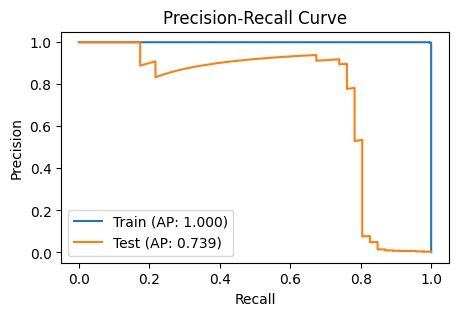

In [34]:
precision_recall_data = {
    'Train': [],
    'Test': []
}

# --- Plot precision recall curve ---
for dataset, (y, X) in zip(['Train', 'Test'], [(y_train, X_train), (y_test, X_test)]):
    y_pred = loaded_model.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_pred)
    precision_recall_data[dataset] = {
        'precision': precision,
        'recall': recall,
        'ap': average_precision_score(y, y_pred)
    }
ap_train = precision_recall_data['Train']['ap']
ap_test = precision_recall_data['Test']['ap']

plt.figure(figsize=(5, 3))
plt.plot(precision_recall_data['Train']['recall'], precision_recall_data['Train']['precision'], color='C0', label=f'Train (AP: {ap_train:.3f})');
plt.plot(precision_recall_data['Test']['recall'], precision_recall_data['Test']['precision'], color='C1', label=f'Test (AP: {ap_test:.3f})');
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision-Recall Curve');
plt.legend();
plt.show()

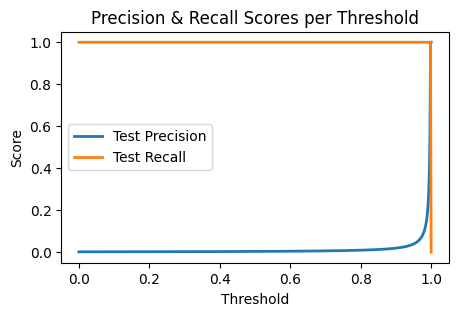

In [35]:
# --- Plot the precision and recall for different thresholds --- 
thresholds = np.linspace(0, 1, len(precision_recall_data['Train']['recall']))

plt.figure(figsize=(5, 3))
plt.plot(thresholds, precision_recall_data['Train']['precision'], color='C0', lw=2, label='Test Precision');
plt.plot(thresholds, precision_recall_data['Train']['recall'], color='C1', lw=2, label='Test Recall');
plt.xlabel('Threshold');
plt.ylabel('Score');
plt.title('Precision & Recall Scores per Threshold');
plt.legend();
plt.show()

---

💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏